# Lista 6 - MS211 turma L

para uma descricao detalhada da teoria empregada nesse trabalho, utilize os documentos relatorio.md e lista06.pdf. As contas utilizadas e desenvolvidas nesse trabalho consistem no modelo compartimental SEIR:

$$\begin{cases}
\frac{d\bold{S}}{dt} = \frac{r_0}{T_{inf}} \bold{S}\bold{I}\\
\frac{d\bold{E}}{dt} = \frac{r_0}{T_{inf}} \bold{S}\bold{I} - \frac{1}{T_{inc}} \bold{E}\\
\frac{d\bold{I}}{dt} = \frac{r_0}{T_{inc}} \bold{S}\bold{I} - \frac{1}{T_{inf}} \bold{I}\\
\frac{d\bold{R}}{dt} = \frac{1}{T_{inf}} \bold{I}
\end{cases}$$

Onde:

- $r_0$ eh o numero de reprodução basal e representa onúmero de pessoas que um doente iria infectar em média durante o curso de sua doença
- $T_{inc}$ eh o tempo de incubacao do virus em uma pessoa exposta
- E $T_{inf}$ eh o tempo médio que a pessoa fica infecciosa



Como condicoes de contorno para o problema, teremos dados conhecidos da pandemia de Covid-19, adotando:

- Número de reprodução basal ($r_0$): 2.5, sendo otimista (adimensional)

- Tempos médio de incubação e infecção:$T_{inc}= 5.2$ dias,$T_{inf}= 2.9$ dias

- Demanda de leitos de UTI: estimava-se que 3% dos doentes precisariamde leito de UTI

- Mediana dos tempos de UTI: 7 dias

- Disponibilidade de leitos de UTI na região Sudeste em 2019 (antes dapandemia): 27 por 100 mil habitantes

- Condição inicial:$S_0 = 0.999999$,$E_0 = 10−6$,$I_0= 0$,$R_0= 0$. Ou seja, há uma pessoa por milhão na população que está exposta e ainda não começou a transmitir a doença. Todo o restante da população é suscetível.

Para a resolucao do problema utilizaremos o algoritmo do método do ponto médio para EDO vetoriais.

O horizonte de simulação sera de 498 dias com um passo de um dia.

## Perguntas a serem respondidas

1. Qual a maior proporção de pessoas doentes observadas em um único dia? Considerando que o estado de São Paulo possui 44,04 milhões de habitantes, essa proporção representa quantas pessoas doentes ao mesmo em umestado como o nosso?

2. Quantos dias são necessários para chegar no pico de doentes?

3. Estime o número de leitos de UTI para lidar com o pico. Note que isso precisa ser feito com cuidado.  Não basta multiplicar o pico de I pela necessidade de leitos. Você tem que levar em consideração a dinâmica e o tempo em UTI. O que você deve:
- (a) Os compartimento I não diz quantos novos doentes há por dia, elediz a proporção de pessoas doentes, mas eles podem estar doentes hávários dias (o tempo médio em I é de 2.9 dias). Para saber o fluxo de novos doentes, a forma mais eficaz é ver o fluxo de pessoas saindo de S, que se tornaram doentes depois de Tinc dias de incubação, ou o número de pessoas entrando diariamente em R que pararam detransmitir a doença naquele dia (seja porque se curaram, seja porque foram parar no hospital). Nesse sentido é mais natural considerar o fluxo diário de pessoas transitando de I para R como o fluxo de novos doentes que podem ir parar na UTI. Calcule e use esse número.
- (b) Multiplicando esse fluxo de novos doentes pela a demanda de leitos de UTI por doente dada acima, você descobre quantos novos leitos são necessários a cada dia.
- (c) Mas os leitos não são usados por um único dia, sim por 7 dias (veja acima). Então para estimar a necessidade total de leitos você deve somar essa demanda de novos leitos por 7 dias em todo o horizonteda simulação.(d) O número máximo de leitos necessários é então o máximo dessa somaem janela deslizante de 7 dias.
4. O número de leitos disponíveis é suficiente para lidar com o pico de demanda? Qual o excesso de demanda máximo, se houver?
5. Você consegue estimar quantas pessoas ao todo iriam ficar sem acesso a UTIs? Justifique a forma que você fez essa estimativa.
6. Com base nessa simulação o que você diria ao governador do estado no início da pandemia? As restrições de circulação foram necessárias?

In [6]:
using LinearAlgebra, Statistics, Random, SparseArrays
using Plots
using LaTeXStrings
using Printf
#using OrdinaryDiffEq
#using Parameters, Plots

In [7]:
r0 = 2.5 # numero de reproducao basal
Tinc = 5.2 # incubacao de 5.2 dias
Tinf = 2.9 # infeccaopor 2.9 dias
prob_UTI = 3/100 # probabilidade de um doente precisar de leito de prob_dem_UTI
t_UTI = 7 # tempo passado na UTI
S = 0.999999 # sucetiveis iniciais
E = 10^(-6) # expostos iniciais
I = 0 # infectados iniciais
R = 0 # recuperados iniciais
leitos_por_100k =27 # 27 leitos para cada 100 mil habitantes * total da populacao
days = (0.0, 480.0) # range of days from simulation

(0.0, 480.0)

In [8]:
# essas expressoes estao corretas, eu copiei errado ali em cima

function SEIR(S, E, I, R, r0, Tinc, Tinf)
	return [
		-(r0/Tinf)*S*I; #dS
		(r0/Tinf)*S*I - (E/Tinc); #dE
		(E/Tinc) - (I/Tinf); #dI
		(I/Tinf); #dR
	]
end

SEIR(S, E, I, R, r0, Tinc, Tinf)

4-element Vector{Float64}:
 -0.0
 -1.9230769230769237e-7
  1.9230769230769237e-7
  0.0

In [9]:
# Teste com equação boba y'= y, y(0) = 1 em [0, 2].
f(t, y) = y
n = 1000

# Método de Ponto médio para PVI y' = f(t, y), y(a) = y0, usando n pontos.
function PontoMedio(a, b, f, y0, n::Int64)
	h = (b - a) / n
	y = zeros(n + 1)
	y[1] = y0
	t = a
	for i = 2:n + 1
		y01 = y[1,i - 1] + (h/2)*f(t, y[1,i - 1])
		y02 = y[2,i - 1] + (h/2)*f(t, y[2,i - 1])
		y03 = y[3,i - 1] + (h/2)*f(t, y[3,i - 1])
		y04 = y[4,i - 1] + (h/2)*f(t, y[4,i - 1])
		t += h/2
		y[1,i] = y[1,i - 1] + h*f(t, y01)
		y[2,i] = y[2,i - 1] + h*f(t, y02)
		y[3,i] = y[3,i - 1] + h*f(t, y03)
		y[4,i] = y[4,i - 1] + h*f(t, y04)
		t += h/2
	end
	return y
end
#y = PontoMedio(0, 2, f, 1, round(Int64, n / 10))
#@printf("\nPonto médio com 10%% dos pontos:\n")
#@printf("Valor aproximado = %f\n", y[end])
#@printf("Erro relativo = %.2e\n", abs(y[end] - exp(2))/exp(2))

PontoMedio (generic function with 1 method)

In [ ]:
# Teste com equação boba y'= y, y(0) = 1 em [0, 2].
f(t, y) = y
n = 1000

# Método de Ponto médio para PVI y' = f(t, y), y(a) = y0, usando n pontos.
function PontoMedio(SEIR, S, E, I, R, r0, Tinc, Tinf, days, step)
	h = step
	y = zeros(4, days + 1)
	y[1, 1] = S
	y[2, 1] = E
	y[3, 1] = I
	y[4, 1] = R
	t = 1
	for i = 2:days + 1
		result = SEIR(y[1,i - 1], y[2,i - 1],y[3,i - 1], y[4,i - 1], r0, Tinc, Tinf)
		y1 = y[1,i - 1] + (h/2)*result[1]
		y2 = y[2,i - 1] + (h/2)*result[2]
		y3 = y[3,i - 1] + (h/2)*result[3]
		y4 = y[4,i - 1] + (h/2)*result[4]
		t += h/2
		result2 = SEIR(y1, y2,y3, y4, r0, Tinc, Tinf)
		y[1,i] = y[1,i - 1] + h*result2[1]
		y[2,i] = y[2,i - 1] + h*result2[2]
		y[3,i] = y[3,i - 1] + h*result2[3]
		y[4,i] = y[4,i - 1] + h*result2[4]
		t += h/2
	end
	return y
end

In [ ]:
y = PontoMedio(SEIR, S, E, I, R, r0, Tinc, Tinf, 468,1)

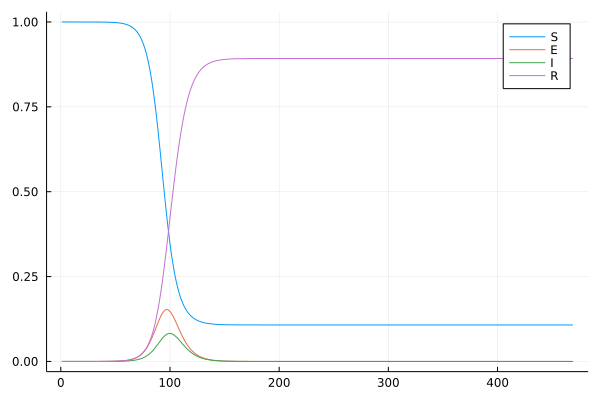

In [25]:
plot([y[1,:],y[2,:],y[3,:],y[4,:]],label=["S" "E" "I" "R"])
